In [418]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.tabular import * 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing data
 Combining train+test into full dataframe

In [419]:
train = pd.read_csv("titanic_train.csv", low_memory="False")
test = pd.read_csv("test.csv", low_memory="False")
full = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
full = full.drop('Ticket', axis = 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [420]:
display_all(full)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN


# Cleaning

In [421]:
# Percentage of missing values per column
display_all(full.isnull().sum().sort_index()/len(full))

Age            0.200917
Cabin          0.774637
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.319328
dtype: float64

In [422]:
full.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived'],
      dtype='object')

In [423]:
cont_list, cat_list = cont_cat_split(df=full, max_card=20, dep_var='Survived')
cont_list, cat_list

(['Age', 'Fare', 'PassengerId'],
 ['Cabin', 'Embarked', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp'])

In [424]:
cat_names = ['Cabin', 'Embarked', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp']
cont_names = ['Age', 'Fare', 'PassengerId']

tfm = Categorify(cat_names, cont_names)
tfm(full)

tfm = FillMissing(cat_names, cont_names)
tfm(full)

full["Embarked"] = full["Embarked"].fillna("S")


In [425]:
display_all(full.isnull().sum().sort_index()/len(full))

Age            0.000000
Age_na         0.000000
Cabin          0.774637
Embarked       0.000000
Fare           0.000000
Fare_na        0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.319328
dtype: float64

In [426]:
display_all(full)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Age_na,Fare_na
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,False,False
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,False,False
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,False,False
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,False,False
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,True,False
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,False,False
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,False,False
1307,28.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,True,False


# Feature Engineering

In [427]:
full = full.drop('Cabin', axis=1)
full['Sex'].replace(['male','female'],[0,1],inplace=True)
full['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in full["Name"]]
full["Title"] = pd.Series(dataset_title)

full["Title"] = full["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full["Title"] = full["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
full["Title"] = full["Title"].astype(int)
full.drop(labels = ["Name"], axis = 1, inplace = True)
full.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Age_na,Fare_na,Title
0,22.0,0,7.2500,0,1,3,0,1,0.0,False,False,2
1,38.0,1,71.2833,0,2,1,1,1,1.0,False,False,1
2,26.0,0,7.9250,0,3,3,1,0,1.0,False,False,1
3,35.0,0,53.1000,0,4,1,1,1,1.0,False,False,1
4,35.0,0,8.0500,0,5,3,0,0,0.0,False,False,2


In [428]:
full['Survived'] = full['Survived'].replace(np.NaN, 0)

# Splitting into train/test sets from full dataframe

In [429]:
x = full.loc[:, full.columns != 'Survived']
y = full.Survived

In [430]:
# create a split set to avoid overfitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)

# Random Forest Classifier

In [431]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [432]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=3000, random_state=42, oob_score=True)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8244274809160306


Accuracy: 0.8129770992366412
Feature ranking:
1. feature 4 (0.324227)
2. feature 6 (0.155099)
3. feature 2 (0.139838)
4. feature 0 (0.116928)
5. feature 5 (0.072765)
6. feature 10 (0.068613)
7. feature 7 (0.041897)
8. feature 3 (0.033776)
9. feature 1 (0.033269)
10. feature 8 (0.013577)
11. feature 9 (0.000011)


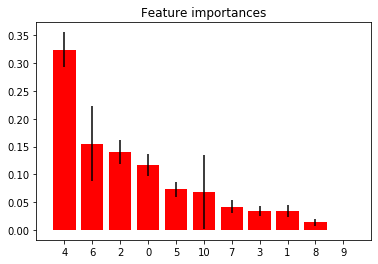

In [434]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=1000, random_state=17, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()